In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
    
    return mean_results


## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

import numpy as np
import xarray as xr
from scipy.stats import t

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.DataArrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, standard error on regression,
    and R-squared between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    # 1. Ensure that the data are properly aligned to each other. 
    x, y = xr.align(x, y)
    
    # 2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        x = x.shift(time=-lagx).dropna(dim='time')
        x, y = xr.align(x, y)

    if lagy != 0:
        y = y.shift(time=-lagy).dropna(dim='time')
        x, y = xr.align(x, y)
 
    # 3. Compute data length, mean and standard deviation along time axis for further use
    n = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    # 4. Compute covariance along time axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / n
    
    # 5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    # 6. Compute regression slope and intercept
    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope
    y_pred = intercept + slope * x
    res = y - y_pred

    # 7. Compute P-value and standard error
    # Compute t-statistics
    tstats = cor * np.sqrt(n-2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats
    
    pval = t.sf(tstats, n-2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # 8. Compute R-squared
    sst = np.sum((y - ymean) ** 2, axis=0)
    ssr = np.sum(res ** 2, axis=0)
    r_squared = 1 - ssr / sst

    r_squared = xr.DataArray(r_squared, dims=cor.dims, coords=cor.coords)

    return slope #, intercept, pval, stderr, r_squared, y_pred


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [4]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

# -- Create directories
checkDir(out_path)

### Open 1pctCO2-bgc data

NEP

In [5]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-bgc'
var_name = 'nep'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_nep.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_nep):
    ds_nep[i] = ds_nep[i].isel(time = slice(0,1680))
    ds_nep[i] = ds_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_nep[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_nep[i] = ds_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_nep[i] = ds_nep[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_nep[i] = ds_nep[i].where(ds_nep[i] != -3.7270379e-07)


In [6]:
for i, item in enumerate(ds_nep):
    if item.esm in {"BCC-CSM2-MR","E3SM-1-1-ECA","TaiESM1"}: #,"MRI-ESM2-0", "NorESM2-MM"
        del ds_nep[i]
    print(ds_nep[i].esm)

ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


NBP

In [7]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-bgc'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_nbp.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_nbp):
    ds_nbp[i] = ds_nbp[i].isel(time = slice(0,1680))
    ds_nbp[i] = ds_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_nbp[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_nbp[i] = ds_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_nbp[i] = ds_nbp[i].resample(time="Y", label='right').mean()


# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_nbp[i] = ds_nbp[i].where(ds_nbp[i] != -3.7270379e-07)


In [8]:
for i, item in enumerate(ds_nbp):
    if item.esm in {"BCC-CSM2-MR","E3SM-1-1-ECA","TaiESM1"}: #"MRI-ESM2-0", "NorESM2-MM"
        del ds_nbp[i]
    print(ds_nbp[i].esm)

ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


#### Define list of models and realizations

In [9]:
# Initialize lists for models and realizations
models = []
realiz = []

# Collect the models and realizations
for i, item in enumerate(files_list):
    models.append(item.source_id)
    realiz.append(item.variant_label)

# Zip the models and realiz lists together for sorting by source_id (models)
zipped = list(zip(models, realiz))

# Sort by the first element in each tuple (i.e., source_id)
zipped_sorted = sorted(zipped, key=lambda x: x[0])

# Unzip the sorted list back into separate lists for models and realiz
models_sorted, realiz_sorted = zip(*zipped_sorted)

# Convert them back to lists if needed
models_sorted = list(models_sorted)
realiz_sorted = list(realiz_sorted)

### Open CO2

In [10]:

data = np.loadtxt('F:/Data/analysis/1pctCO2-bgc/co2_1pctCO2-bgc.txt')

# Extract lon, lat, and data values from the loaded data
time = data[:140, 0]
values = data[:140, 1]

ds_co2 = []
for i,item in enumerate(ds_nep):

    lons = item.lon.values
    lats = item.lat.values

    # Create coordinate arrays
    time_coords = pd.date_range(start = "1850", periods=time.shape[0], freq = "YS") # xr.DataArray(time, dims='time', name='time')
    lon_coords = xr.DataArray(lons, dims='lon', name='lon')
    lat_coords = xr.DataArray(lats, dims='lat', name='lat')

    # Create a sample data array with a constant value for all grid cells
    constant_value = 10  # Replace with your desired constant value
    data_values = np.full((len(time), len(lats), len(lons)), constant_value)

    # Create the DataArray
    co2 = xr.DataArray(data_values, 
                            coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
                            dims=['time', 'lat', 'lon'],
                            name='ppm').astype("float64")

    for i,item in enumerate(time):
        co2[i] = values[i]
    ds_co2.append(co2)

ds_co2 = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_co2]

### Linear Regression of NEP and CO2

The relationship between NEP and CO2 is logarithimic, but if we consider the range of CO2 ppm of historical (280-400) and ssp585 (400-1135) separately, it is linear.\
For historical, the period is from 1850-01 to 1885-12 (36 yrs). \
For ssp585, the period is from 1886-01-01 to 1989-01-01 (104 yrs).

We calculate the long-term BETA carbon-concentration feeback from the 1pctCO2-bgc simulation as:

\begin{equation}
\Delta NEP_{\text{cum}} = a_{0} + sCO_{2} * \Delta ppm + \epsilon
\end{equation}

We define $\Delta$ as the difference compared to the first year of the simulation. \
We obtain $sCO_{2}$ as $gCm^{-2}yr^{-1}ppm^{-1}$, and we multiply by the number of years of the historical and ssp585 simulations obtaining $gCm^{-2}ppm^{-1}$ 

In [17]:
eco2_nep_hist = []
eco2_nbp_hist = []
ds_co2_hist = ds_co2.copy()

for i, item in enumerate(ds_nep):
    ds_co2_hist[i] = ds_co2[i].assign_coords(lat = ds_nep[i][:35].lat, lon = ds_nep[i][:35].lon, time = ds_nep[i].time)
    Y = ds_nep[i].cumsum(dim = "time"); Y = ds_nep[i][:35] - ds_nep[i][0]
    X = ds_co2[i][:35] - ds_co2[i][0]
    slope = lag_linregress_3D(X,Y); slope = slope.assign_attrs(esm = ds_nep[i].esm)

    ds_co2_hist[i] = ds_co2[i].assign_coords(lat = ds_nbp[i][:35].lat, lon = ds_nbp[i][:35].lon, time = ds_nbp[i].time)
    Y = ds_nbp[i].cumsum(dim = "time"); Y = ds_nbp[i][:35] - ds_nbp[i][0]
    slope1 = lag_linregress_3D(X,Y); slope1 = slope1.assign_attrs(esm = ds_nbp[i].esm)

    eco2_nep_hist.append(slope*(2014-1850))
    eco2_nbp_hist.append(slope1*(2014-1850))

In [18]:
eco2_nep = []
eco2_nbp = []

for i, item in enumerate(ds_nep):
    ds_co2[i] = ds_co2[i].assign_coords(lat = ds_nep[i][36:].lat, lon = ds_nep[i][36:].lon, time = ds_nep[i].time)
    Y = ds_nep[i].cumsum(dim = "time"); Y = ds_nep[i][36:] - ds_nep[i][36]
    X = ds_co2[i][36:] - ds_co2[i][36]
    slope = lag_linregress_3D(X,Y); slope = slope.assign_attrs(esm = ds_nep[i].esm)

    ds_co2[i] = ds_co2[i].assign_coords(lat = ds_nbp[i][36:].lat, lon = ds_nbp[i][36:].lon, time = ds_nbp[i].time)
    Y = ds_nbp[i].cumsum(dim = "time"); Y = ds_nbp[i][36:] - ds_nbp[i][36]
    slope1 = lag_linregress_3D(X,Y); slope1 = slope1.assign_attrs(esm = ds_nbp[i].esm)

    eco2_nep.append(slope*(2100-2015))
    eco2_nbp.append(slope1*(2100-2015))

Zonal means

In [23]:
beta_nep_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in eco2_nep]
beta_nbp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in eco2_nbp]

beta_nep_amz = [a.rename("nep") for a in beta_nep_amz]
beta_nbp_amz = [a.rename("nbp") for a in beta_nbp_amz]

# df_coef_ridge_ssp_pr = xr.concat(coef_ridge_ssp_pr_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_pr = df_coef_ridge_ssp_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_pr.index, models)))
beta_nep_amz = xr.concat(beta_nep_amz, dim = "models").to_dataframe(); beta_nep_amz = beta_nep_amz.drop(columns = ["region"]).rename(index=dict(zip(beta_nep_amz.index, models)))
beta_nbp_amz = xr.concat(beta_nbp_amz, dim = "models").to_dataframe(); beta_nbp_amz = beta_nbp_amz.drop(columns = "region").rename(index=dict(zip(beta_nbp_amz.index, models)))

beta_amz = pd.concat([beta_nep_amz, beta_nbp_amz, ], axis = 1)

<AxesSubplot: xlabel='models'>

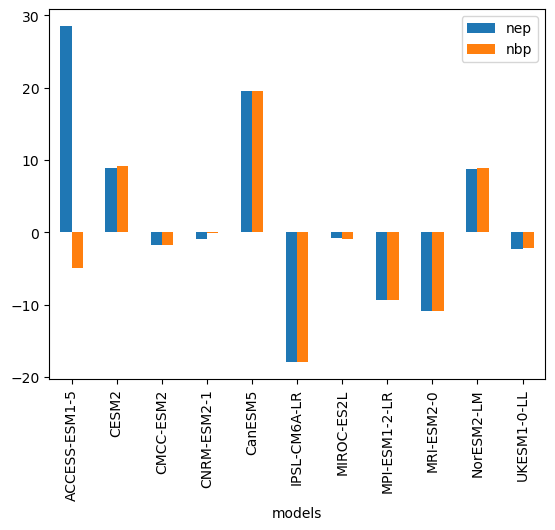

In [24]:
beta_amz.plot.bar(stacked = False)